<center><b><font size="+3">FAKE NEW DETECTION</font></b></center>

<center>
    <img src="https://miro.medium.com/max/3840/1*CQaCf35n3pReVZ02iYK0Xg.jpeg" width="1600" height="600" alt="cognitiveclass.ai logo"  />
</center>

# Link web test

Link test được deploy trên nền tảng `streamlit` do thầy cô gợi ý. Link [tai đây](https://share.streamlit.io/lavdata/fake_new_detector/main/pr.py)

---

# Thông tin thành viên và phân công nhiệm vụ

|MSSV    | HO TEN        | NHIEM VU    |
|:-------|:--------------|:-----------:|
|...| Phạm Thành Đạt| Tiền xử lí, EDA. Hỗ trợ, nhận xét phần 3, 4       |
|...| Trần Bảo Tín  | Tiền xử lí, EDA. Hỗ trợ, nhận xét phần 3, 4   |
|19120724| Lê Anh Vũ     | Mô hình hóa, Deploy model. Hỗ trợ, nhận xét phần 1, 2 |
|...| Nguyễn Phú Thụ| Mô hình hóa, Deploy model. Hỗ trợ, nhận xét phần 1, 2|

# Import các thư viện cần thiết

In [5]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Thư viện ngoài
from pyvi import ViTokenizer

`pyvi` là thư viện ngoài. Em dùng để `Tokenizer` văn bản tiếng việt. Thầy cô chỉ cần cài bằng cách `pip install pyvi`. Thông tin chi tiết [tại đây](https://towardsdatascience.com/introduction-to-pyvi-python-vietnamese-nlp-toolkit-ff5124983dc2)

# Nguồn dữ liệu

File `vn_news_223_tdlfr.csv` được lấy từ [VNFD Dataset](https://github.com/thanhhocse96/vfnd-vietnamese-fake-news-datasets/blob/master/CSV/vn_news_223_tdlfr.csv)
- Tập dữ liệu 223 record bản tin tiếng Việt, gồm 2 nhãn: 1 (tin giả) và 0 (tin thật) 
- Mô tả dữ liệu: được lấy từ [VNFD](https://github.com/thanhhocse96/vfnd-vietnamese-fake-news-datasets/tree/master/CSV)

File `vietnamese-stopwords.txt` chứa các từ `stopword` được lấy từ [VNStopword](https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt)

# Tiền xử lý văn bản tiếng Việt

Dữ liệu được lấy từ file `vn_news_223_tdlfr.csv`

In [6]:
news_df = pd.read_csv('vn_news_223_tdlfr.csv', encoding='utf-8')
news_df.sample(5)

,text,domain,label
196,Trung Quốc hủy nhiều chuyến bay tới Thường Châ...,vnexpress.net,0
67,"Mặc đồ không khác gì vải màn lên bar đú đởn, M...",tinvn.info,1
81,"Nếu thấy thứ này thò lên ngoài vườn nhà, đừng ...",tinvn.info,1
121,Người đàn ông chết khô ở máy dập có thể do đột...,tuoitre.vn,0
141,Ôtô 'chôn chân' vì bị chặn đầu bởi trăm xe máy...,vnexpress.net,0


## Dữ liệu có bị trùng lặp hay không? Nếu có thì loại bỏ chúng

In [7]:
len(news_df) - len(news_df.drop_duplicates())

1

Vậy dữ liệu có 1 dòng bị trùng. Ta sẽ tiến hành loại bỏ nó.

In [8]:
news_df = news_df.drop_duplicates()
news_df.shape

(222, 3)

In [9]:
assert len(news_df) == len(news_df.drop_duplicates())

## Tiền xử lí cơ bản

### Đọc file `vietnamese-stopwords.txt` để lưu 1 set các từ stopword

In [10]:
stopword = open('./vietnamese-stopwords.txt', 'r', encoding='utf-8')
stopword = set([i.rstrip() for i in stopword.readlines()])

### Hàm loại bỏ các dấu câu, lowercase và loại stopword

- Trước tiên, em sẽ định nghĩa các kí hiệu `noise`.
- Sau đó thay thế khoảng trắng giữa các stopword bằng dấu `_`. Lý do: vì khi tokenize chữ thì các cụm từ có dấu`_`  nối giữa các từ.
- Tiếp theo, là các bước loại bỏ các kí hiệu `noise`, `tokenizer`,`lowercase` và loại bỏ `stopword` trong phần text
- Cuối cùng, đó là thêm phần tên miền vào list `clean_test`

In [11]:
puncs = string.punctuation + '\n“”‘’'
puncs

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n“”‘’'

In [12]:
stopword = pd.Series(list(stopword)).str.replace(' ', '_').to_list()
stopword[:5]

['buổi_ngày', 'ào_vào', 'tên_tự', 'có_khi', 'nào_phải']

In [13]:
def remove_stopword(x):
    return [i.rstrip('_') for i in x if i not in stopword and i not in [',', '']]


clean_text = news_df['text'].replace(f'[{puncs}]', ',', regex=True).\
    apply(ViTokenizer.tokenize).str.lower().\
    str.split().apply(remove_stopword)

clean_text.sample(5)

1      [thủ_tướng, nhật, cúi, đầu, xin_lỗi, tinh_thần...
93     [liên_tục, con_trai, báo_mộng, mẹ, kinh_hãi, c...
209    [khởi_tố, cặp, nữ, quái, chuyên, cung_cấp, ma_...
126    [tuyến, buýt, 5, tân_sơn, đi, vũng_tàu, tp, hc...
55     [phát_hoảng, tiếng, rít, đinh_tai, đêm, chạy, ...
Name: text, dtype: object

In [14]:
news_df['clean_text'] = clean_text
news_df['clean_text'] = news_df.apply(lambda x: ' '.join(
    x['clean_text']) + ' ' + x['domain'], axis=1)

news_df.head(5)

,text,domain,label,clean_text
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1,thủ_tướng abe cúi đầu xin_lỗi hành_động phi th...
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1,thủ_tướng nhật cúi đầu xin_lỗi tinh_thần phi t...
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1,choáng cơ_trưởng đeo khăn_quàng quẩy banh sân_...
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1,nhạc kpop hát giáo_sư nguyễn_lân dũng thành_đạ...
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1,đại_học hutech áp_dụng cải_cách tiếq việt năm_...


# Khám phá dữ liệu

## Dữ liệu có bao nhiêu dòng cột?

In [15]:
news_df.shape

(222, 4)

In [16]:
print(f"Vậy dữ liệu có {news_df.shape[0]} dòng và {news_df.shape[1]} cột.")

Vậy dữ liệu có 222 dòng và 4 cột.


## Dữ liệu có bị thiếu hay không?

In [17]:
news_df.isnull().sum()

text          0
domain        0
label         0
clean_text    0
dtype: int64

## Các kiểu dữ liệu của các cột đã phù hợp hay chưa?

In [18]:
news_df.dtypes

text          object
domain        object
label          int64
clean_text    object
dtype: object

*Nhìn qua ta có thể thấy các cột dữ liệu đã có kiểu dữ liệu thích hợp. Tuy nhiên để chắc chắn hơn ta cần kiểm tra cột dữ liệu ở các cột `text`, `domain`, vì kiểu dữ liệu object có thể có nhiều kiểu dữ liệu khác nhau trong đó*

In [19]:
def open_object_dtype(s):
    dtypes = set()
    s.apply(lambda x: dtypes.add(type(x)))
    return dtypes

In [20]:
# TEST
assert open_object_dtype(news_df['text']) == {str}
assert open_object_dtype(news_df['domain']) == {str}
assert open_object_dtype(news_df['clean_text']) == {str}

*Vậy là các cột dữ liệu thuộc kiểu object đều có dạng chuỗi, thỏa với mục đích cần tìm*

## Các giá trị trong cột dữ liệu `label` có sự phân bố như thế nào?

<AxesSubplot:>

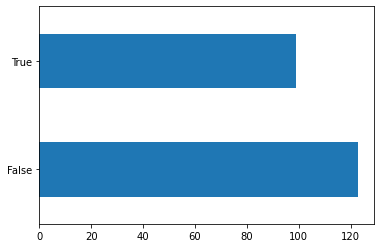

In [21]:
news_df['label'].value_counts().rename(
    index={0: 'False', 1: 'True'}).plot.barh()

**Nhận xét:** Sự phân bố 2 giá trị FAKE (tin giả) và REAL (tin thật) chênh lệch không nhiều khi dữ liệu tin thật chiếm hơn 120 tin trong khi đó ở tin giả là 100 tin  

## Sự phân bố của cột dữ liệu `domain`

Text(0, 0.5, 'Number of occurences')

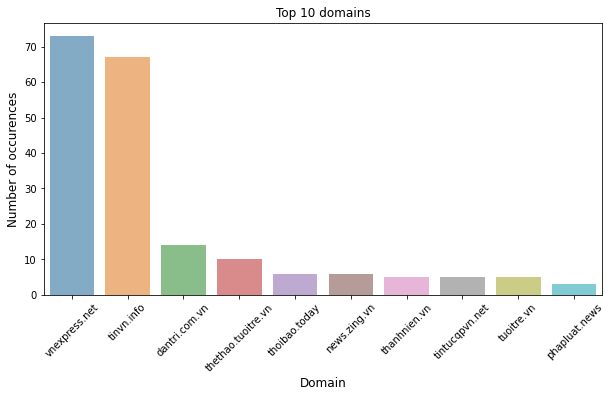

In [22]:
top_ten_domain = news_df['domain'].value_counts()[:10]

plt.figure(figsize=(10, 5))
sns.barplot(x=top_ten_domain.index, y=top_ten_domain.values, alpha=0.6)
plt.title('Top 10 domains')
plt.xlabel('Domain', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Number of occurences', fontsize=12)

**Nhận xét:** Trong top 10 domain được sử dụng nhiều nhất để đăng tin thì ta thấy có sự chênh lệch rõ rệt khi 2 domain `vnexpress.net` và `tinvn.info` chiếm số lượng vượt trội so với phần còn lại  

## Khám phá cột dữ liệu `text`

- Thông tin thống kê của văn bản

In [23]:
# Lấy các thông tin thống kê của văn bản
text_col = news_df['text'].apply(lambda x: len(x))


def lower_quantile(df):
    return df.quantile(0.25).round()


def median(df):
    return df.quantile(0.5).round()


def upper_quantile(df):
    return df.quantile(0.75).round()


text_col.agg(['min', lower_quantile, median, upper_quantile, 'max'])

min                 309.0
lower_quantile     1280.0
median             1988.0
upper_quantile     3285.0
max               10019.0
Name: text, dtype: float64

# Mô hình hóa

## Tokenize văn bản

In [24]:
train_data = TfidfVectorizer(lowercase=False).fit_transform(news_df['clean_text'])

## Chia dữ liệu

Ở phần này, nhóm em quyết định chia tập dữ liệu thành 3 phần:
- Phần train chiếm 75%
- Phần valid data chiếm 15%
- Phần test chiếm 10%

In [25]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(
    train_data, news_df.label, test_size=1 - train_ratio, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

## Mô hình tuyến tính

Với mô hình tuyến tính, em sử dụng bộ phân lớp `LogisticRegressionCV`

### Tìm mô hình tốt nhất

In [26]:
train_accs = []
val_accs = []
cvs = [5, 6, 7, 8, 9, 10]
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
best_val_acc = 0
best_cv = None
best_solver = None

for cv in cvs:
    for solver in solvers:
        lg_re = LogisticRegressionCV(
            Cs=20, cv=cv, solver=solver, max_iter=10000).fit(x_train, y_train)
        val_accs.append(accuracy_score(lg_re.predict(x_val), y_val))
        train_accs.append(accuracy_score(lg_re.predict(x_test), y_test))

best_val_acc = max(val_accs)
index_best = val_accs.index(best_val_acc)
best_cv = cvs[index_best // len(solvers)]
best_solver = solvers[index_best % len(solvers)]

In [27]:
lg_re.set_params(cv=best_cv, solver=best_solver).fit(x_train, y_train)

LogisticRegressionCV(Cs=20, cv=5, max_iter=10000, solver='newton-cg')

In [28]:
print(f"Vậy các tham số tốt nhất với mô hình này tìm được là Cs=20, cv={best_cv}, max_iter=1000, solver={best_solver}")

Vậy các tham số tốt nhất với mô hình này tìm được là Cs=20, cv=5, max_iter=1000, solver=newton-cg


In [29]:
accuracy_score(y_true=y_test, y_pred=lg_re.predict(x_test))

0.9565217391304348

**Nhận xét:** Tỉ lệ khớp với tập test khá cao.

### Trực quan hóa kết quả

Text(386.9318181818181, 0.5, 'cv')

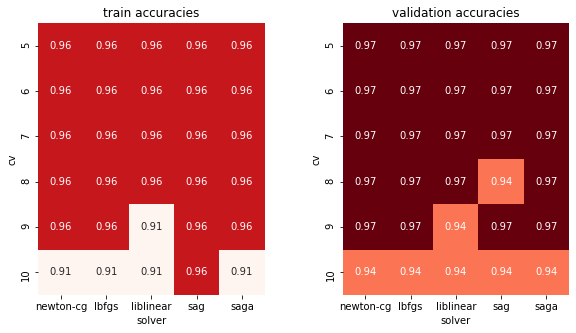

In [30]:
# Trực quan hóa kết quả
train_accs_df = pd.DataFrame(data=np.array(train_accs).reshape(len(cvs), -1),
                             index=cvs, columns=solvers)
val_accs_df = pd.DataFrame(
    data=np.array(val_accs).reshape(len(cvs), -1),
    index=cvs, columns=solvers)
min_err = min(min(train_accs), min(val_accs))
max_err = max(max(train_accs), max(val_accs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_accs_df, vmin=min_err, vmax=max_err, square=True,
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('train accuracies')
plt.xlabel('solver')
plt.ylabel('cv')
plt.subplot(1, 2, 2)
sns.heatmap(val_accs_df, vmin=min_err, vmax=max_err, square=True,
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('validation accuracies')
plt.xlabel('solver')
plt.ylabel('cv')

**Nhận xét:** tỉ lệ tập `train` và tập `valid` khá tương đồng nhau. Số `k-fold cross validation` càng nhiều, tỉ lệ chính xác càng giảm, kéo theo giảm bớt hiện tượng overfitting

### Lưu model

In [48]:
dump(lg_re, "lg_re")

['lg_re']

## Mô hình phi tuyến

Với mô hìn này, em sử dụng bộ phân lớp `DecisionTreeClassifier`

### Tìm mô hình tốt nhất

In [31]:
train_accs = []
val_accs = []
max_features = ['auto', 'sqrt', 'log2', None]
max_leaf_nodes = [30, 100, 300, 1000]
best_val_acc = 0
best_features = None
best_leaf_nodes = None

for max_feature in max_features:
    for max_leaf_node in max_leaf_nodes:
        tree = DecisionTreeClassifier(
            random_state=42, max_features=max_feature, max_leaf_nodes=max_leaf_node).fit(x_train, y_train)
        val_accs.append(accuracy_score(tree.predict(x_val), y_val))
        train_accs.append(accuracy_score(tree.predict(x_train), y_train))

best_val_acc = max(val_accs)
index_best = val_accs.index(best_val_acc)
best_features = max_features[index_best // len(max_leaf_nodes)]
best_leaf_nodes = max_leaf_nodes[index_best % len(max_leaf_nodes)]

In [32]:
tree.set_params(random_state=42, max_features=best_features,
                max_leaf_nodes=best_leaf_nodes).fit(x_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=30, random_state=42)

In [33]:
print(
    f"Vậy các tham số tốt nhất với mô hình này tìm được là random_state=42, max_features={best_features}, max_leaf_nodes={best_leaf_nodes}")

Vậy các tham số tốt nhất với mô hình này tìm được là random_state=42, max_features=None, max_leaf_nodes=30


In [34]:
accuracy_score(y_test, tree.predict(x_test))

0.9130434782608695

### Trực quan hóa kết quả

Text(373.36363636363626, 0.5, 'max_features')

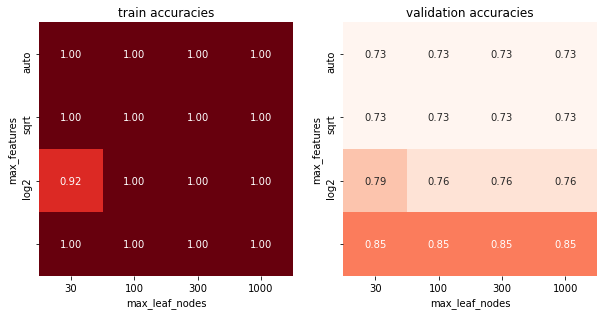

In [35]:
# Trực quan hóa kết quả
train_accs_df = pd.DataFrame(data=np.array(train_accs).reshape(len(max_features), -1),
                             index=max_features, columns=max_leaf_nodes)
val_accs_df = pd.DataFrame(
    data=np.array(val_accs).reshape(len(max_features), -1),
    index=max_features, columns=max_leaf_nodes)
min_err = min(min(train_accs), min(val_accs))
max_err = max(max(train_accs), max(val_accs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_accs_df, vmin=min_err, vmax=max_err, square=True,
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('train accuracies')
plt.xlabel('max_leaf_nodes')
plt.ylabel('max_features')
plt.subplot(1, 2, 2)
sns.heatmap(val_accs_df, vmin=min_err, vmax=max_err, square=True,
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('validation accuracies')
plt.xlabel('max_leaf_nodes')
plt.ylabel('max_features')

**Nhận xét:** TỈ lệ trên tập `train` khác biệt hoàn toàn đối với tập `valid`. 
- Theo kinh nghiệm của em, phân lớp bằng cây rất dễ bị hiện tượng `overfitting`, dễ thấy, tỉ lệ ở tập `train` đều đạt điểm tuyệt đối. 
- Đối với tỉ lệ tập `valid`, việc số `features` càng giảm thì có vẻ tỉ lệ khớp càng nhỏ đi. Với trường hợp `max_feautures == None`, ta thấy có giá trị khác rõ với các tham số còn lại. Có vẻ đây là dấu hiệu của việc khớp khá khít. 

### Lưu model

In [47]:
dump(tree, "tree")

['tree']

## Deep learning

Với mô hình này, em sử dụng bộ phân lớp `MLPClassifer`

### Tìm mô hình tốt nhất

In [36]:
train_accs = []
val_accs = []
alphas = [0, 0.01, 0.1, 1, 10, 100]
solvers = ['lbfgs', 'sgd', 'adam']
best_val_acc = 0
best_alpha = None
best_solver = None

for alpha in alphas:
    for solver in solvers:
        MLPC = MLPClassifier(hidden_layer_sizes=(50), alpha=alpha, solver=solver, max_iter=10000).fit(x_train, y_train)
        val_accs.append(accuracy_score(MLPC.predict(x_val), y_val))
        train_accs.append(accuracy_score(MLPC.predict(x_train), y_train))

best_val_acc = max(val_accs)
index_best = val_accs.index(best_val_acc)
best_alpha = alphas[index_best // len(solvers)]
best_solver = solvers[index_best % len(solvers)]

In [37]:
MLPC.set_params(hidden_layer_sizes=(50), alpha=best_alpha,
                solver=best_solver, max_iter=10000).fit(x_train, y_train)

MLPClassifier(alpha=0.1, hidden_layer_sizes=50, max_iter=10000, solver='lbfgs')

In [38]:
print(
    f"Vậy các tham số tốt nhất với mô hình này tìm được là hidden_layer=(50), alpha={best_alpha}, max_iter=10000, solver={best_solver}")

Vậy các tham số tốt nhất với mô hình này tìm được là hidden_layer=(50), alpha=0.1, max_iter=10000, solver=lbfgs


In [39]:
accuracy_score(y_test, MLPC.predict(x_test))

0.9565217391304348

### Trực quan hóa kết quả

Text(432.23181818181814, 0.5, 'alphas')

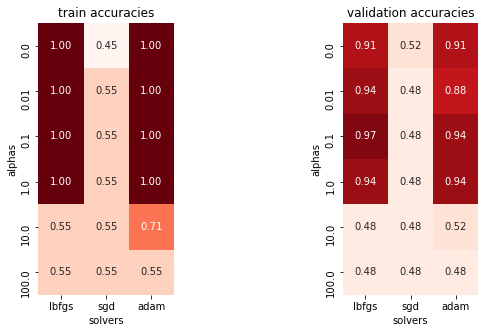

In [40]:
# Trực quan hóa kết quả
train_accs_df = pd.DataFrame(data=np.array(train_accs).reshape(len(alphas), -1),
                             index=alphas, columns=solvers)
val_accs_df = pd.DataFrame(
    data=np.array(val_accs).reshape(len(alphas), -1),
    index=alphas, columns=solvers)
min_err = min(min(train_accs), min(val_accs))
max_err = max(max(train_accs), max(val_accs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_accs_df, vmin=min_err, vmax=max_err, square=True,
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('train accuracies')
plt.xlabel('solvers')
plt.ylabel('alphas')
plt.subplot(1, 2, 2)
sns.heatmap(val_accs_df, vmin=min_err, vmax=max_err, square=True,
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('validation accuracies')
plt.xlabel('solvers')
plt.ylabel('alphas')

**Nhận xét:** Ta thấy có sự tương đồng giữa tỉ lệ 2 tập `train` và `valid`. Với alpha lớn thì tỉ lệ khớp giảm rõ rệt. Bên cạnh đó, không hiểu sao solver 'sgd' tỉ lệ lại thấp hơn nhiều 2 solver còn lại

### Lưu model

In [46]:
dump(MLPC, "MLPC")

['MLPC']

---

# Nguồn tham khảo

 [1] [Nguồn tham khảo xử lí văn bản](https://maelfabien.github.io/machinelearning/NLP_1/#i-what-is-preprocessing)
 
 [2] [Nguồn tham khảo xây dựng mô hình FAKE NEW DETECTOR](https://www.kaggle.com/c/fakenewskdd2020)
 
 [3] [Ngồn tham khảo xây dựng mô hình học sâu]: lab3 môn NMKHDL
 
 [4] [Nguồn tham khảo phát triển app đơn giản bằng `streamlit`](https://www.youtube.com/watch?v=JwSS70SZdyM&t=1637s)

**NOTE**: Trong quá trình đọc, nếu cảm thấy sai sót gì. Em rất vui khi được góp ý của quý thầy cô, email: 19120724@student.hcmus.edu.vn 